#### Colab run

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
cd drive/MyDrive/master_thesis/final_code

/content/drive/.shortcut-targets-by-id/16udig9ZMaNcASs5Maj6kv7tg-TL3PnSE/Master Thesis/final_code


In [3]:
!pip install kornia -qqq
!pip install torchinfo -qqq
!pip install wandb -qqq

In [4]:
!nvidia-smi

Tue Oct  5 15:51:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### End Colab run

In [5]:
import warnings
import time
import pickle 
import wandb

from py_files.args import *

from py_files.functions import *

from py_files.dataset import *

from py_files.cnn_models import *
from py_files.mapping_models import *
from py_files.pigan_model import *

from py_files.load_utils import *
from py_files.data_utils import *
from py_files.plot_utils import *
from py_files.loss_utils import *
from py_files.train_utils import *
from py_files.save_utils import *

# Set the run you want to evaluate 

In [6]:
sorted(os.listdir(path='saved_runs'))

['pi_gan_2021_09_15_14_58_25_only_one_image',
 'pi_gan_2021_09_17_13_02_40_only_one_image_no_encoder',
 'pi_gan_2021_09_17_13_13_05_only_one_image_no_encoder',
 'pi_gan_2021_09_19_11_01_54_test',
 'pi_gan_2021_09_19_11_14_57_test',
 'pi_gan_2021_09_19_11_29_40_test',
 'pi_gan_2021_09_19_11_37_19_test',
 'pi_gan_2021_10_05_08_57_16_colab_sdf_test',
 'pi_gan_2021_10_05_09_00_34__colab_sdf_test',
 'pi_gan_2021_10_05_09_09_50_colab_sdf_test',
 'pi_gan_2021_10_05_09_11_04__colab_sdf_test',
 'pi_gan_2021_10_05_09_12_14___colab_sdf_test',
 'reconstruction_no_data_augmentation',
 'reconstruction_run_1',
 'reconstruction_run_2',
 'reconstruction_run_3',
 'reconstruction_trained_one_image',
 'segmentation_binary',
 'segmentation_binary_deep',
 'segmentation_sdf_lambda_100',
 'segmentation_sdf_lambda_300',
 'segmentation_sdf_max_pool']

In [7]:
runs = sorted(os.listdir(path='saved_runs'))
run = runs[-1]

ARGS = load_args(run, print_changed=False)

print(run)
for var, val in vars(ARGS).items():
    print(f"{var.ljust(25)} \t {val}")

segmentation_sdf_max_pool
device                    	 GPU
print_models              	 True
save_models               	 True
name                      	 _colab
training_setup            	 segmentation
train_encoder_seg         	 True
pretrained                	 None
pretrained_best_dataset   	 train
pretrained_best_loss      	 mask
pretrained_models         	 None
pretrained_lr_reset       	 None
seed                      	 34
n_coords_sample           	 5000
norm_min_max              	 [0, 1]
rotate                    	 True
translate                 	 True
crop                      	 True
stretch                   	 True
flip                      	 False
translate_max_pixels      	 20
stretch_factor            	 1.2
pcmra_epochs              	 5000
mask_epochs               	 5000
batch_size                	 24
eval_every                	 50
shuffle                   	 True
min_lr                    	 1e-05
patience                  	 50
cnn_setup                 	 maxpool
mapping_set

In [8]:
# ARGS.device = "GPU"
DEVICE = set_device(ARGS)

----------------------------------
Using device for training: cuda
----------------------------------


# Evaluation

In [9]:
ARGS.batch_size = 1
ARGS.shuffle = False

train_dl, val_dl, test_dl = initialize_dataloaders(ARGS, DEVICE)

Train subjects: 82
Train batch: ('107',)
Val subjects: 32
Val batch: ('10',)
Test subjects: 30
Test batch: ('133',)


#### Load models

In [10]:
##### loss function #####
mask_criterion = nn.BCELoss()    
pcmra_criterion = nn.MSELoss()  
dice_criterion = calc_dice_loss

In [11]:
def save_output(dataloader, name=None, shape=[24, 128, 128], transform=False):
    pcmras = masks = surfaces = norms_x = norms_y = norms_z = mask_outs = pcmra_outs = torch.Tensor([])

    titles = []

    mask_losses, pcmra_losses, dice_losses = [], [], []

    blur_layer = initialize_blurring_layer(1.0, DEVICE)

    for batch in dataloader: 
        if transform:
            batch = transform_batch(batch, ARGS)

        idxs, subjs, projs, pcmra, coords_array, pcmra_array, mask_array, surface_array, norm_array = \
            get_siren_batch(batch, blur_layer, -1, ARGS)

        coords_array = get_coords(*shape).to(DEVICE)
        coords_array = coords_array.unsqueeze(0).repeat(pcmra_array.shape[0], 1, 1)

        mask_out = get_complete_image(models, pcmra, coords_array, ARGS)
        pcmra_out = get_complete_image(models, pcmra, coords_array, ARGS, output="pcmra")

        for subj, s_pcmra_array, s_mask_array, s_surface_array, s_norm_array, s_pcmra_out, s_mask_out in zip(subjs, pcmra_array, mask_array, surface_array, norm_array, pcmra_out, mask_out):
            if ARGS.segmentation == "sdf":
                s_mask_out = 1 - F.sigmoid(s_mask_out)
            
            if shape == [24, 128, 128]:
                pcmra_losses.append(pcmra_criterion(s_pcmra_out, s_pcmra_array) .item())
                mask_losses.append(mask_criterion(s_mask_out, s_mask_array).item())
                dice_losses.append(dice_criterion(s_mask_out, s_mask_array).item())

            pcmras = torch.cat((pcmras, s_pcmra_array.cpu().view(24, 128, 128).detach().permute(1, 2, 0)), 2)
            masks = torch.cat((masks, s_mask_array.cpu().view(24, 128, 128).detach().permute(1, 2, 0)), 2)
            mask_outs = torch.cat((mask_outs, s_mask_out.cpu().view(shape).detach().permute(1, 2, 0)), 2)
            pcmra_outs = torch.cat((pcmra_outs, s_pcmra_out.cpu().view(shape).detach().permute(1, 2, 0)), 2)

            if ARGS.segmentation == "sdf":
                surfaces = torch.cat((surfaces, s_surface_array.cpu().view(24, 128, 128).detach().permute(1, 2, 0)), 2)
                norms_x = torch.cat((norms_x, s_norm_array[:, 0:1].cpu().view(24, 128, 128).detach().permute(1, 2, 0)), 2)
                norms_y = torch.cat((norms_y, s_norm_array[:, 1:2].cpu().view(24, 128, 128).detach().permute(1, 2, 0)), 2)
                norms_z = torch.cat((norms_z, s_norm_array[:, 2: ].cpu().view(24, 128, 128).detach().permute(1, 2, 0)), 2)

            if shape == [24, 128, 128]:
                titles += [f"{subj}, pcmra loss: {round(pcmra_losses[-1], 3)}, mask loss: {round(mask_losses[-1], 3)}, dice loss: {round(dice_losses[-1], 3)}" for i in range(shape[0])]
        
        # break
    
    
    print("PCMRA loss:", np.array(pcmra_losses).mean().round(6))
    print("Mask loss: ", np.array(mask_losses).mean().round(6))
    print("Dice loss: ", np.array(dice_losses).mean().round(6))
    print(mask_outs.max())
    print(mask_outs.min())


    save_tuples = [(pcmras.numpy(), "pcmras"),
                #    (pcmra_outs.numpy(), "pcmra output"),
                #    (pcmras.numpy() + masks.numpy(), "plus"),
                   (masks.numpy(), "masks"),
                   (mask_outs.numpy(), "mask output"),
                   (mask_outs.numpy().round(), "mask output"),
                #    (surfaces.numpy(), "surface"),
                #    (norms_x.numpy(), "norm x"),
                #    (norms_y.numpy(), "norm y"),
                #    (norms_z.numpy(), "norm z"),
                #    ((1 - F.sigmoid(mask_outs)).numpy().round(), "mask output binary"),
                ]
    
    for slc in range(12, pcmras.shape[2], 96):
        print(titles[slc])
        fig, ax = plt.subplots(1, len(save_tuples), figsize=(20,20))
        for i , (array, title) in enumerate(save_tuples): 
            ax[i].imshow(array[:, :, slc])
        plt.show()

    if name != None:
        path = os.path.join(os.getcwd(), "saved_results", name)
    else: 
        path = os.path.join(os.getcwd(), "saved_results", run)

    Path(f"{path}").mkdir(parents=True, exist_ok=True)   
    
    with open(os.path.join(path, 'titles.pkl'), 'wb') as f:
        pickle.dump(titles, f)

    with open(os.path.join(path, 'images.pkl'), 'wb') as f:
        pickle.dump(save_tuples, f)

    return mask_outs

pi_gan_2021_10_05_09_12_14___colab_sdf_test
CNN
MAPPING
SIREN
PCMRA_MAPPING
PCMRA_SIREN
Loading params from cnn
Loading params from mapping
Loading params from siren


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


PCMRA loss: 0.029768
Mask loss:  0.678723
Dice loss:  1.0
tensor(0.4925)
tensor(0.4921)
133, pcmra loss: 0.057, mask loss: 0.679, dice loss: 1.0


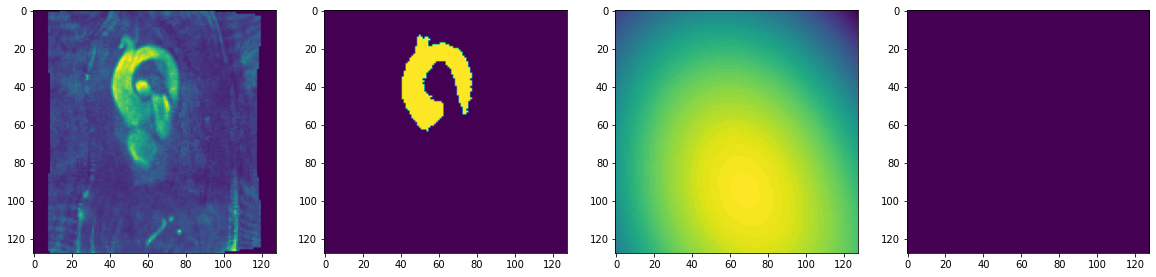

138, pcmra loss: 0.045, mask loss: 0.679, dice loss: 1.0


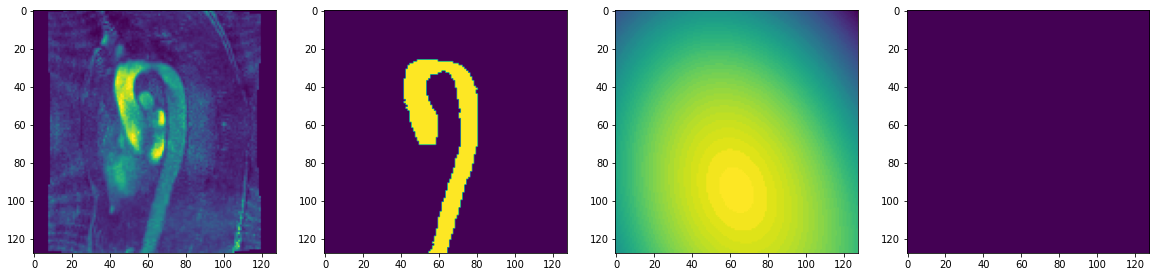

136, pcmra loss: 0.064, mask loss: 0.679, dice loss: 1.0


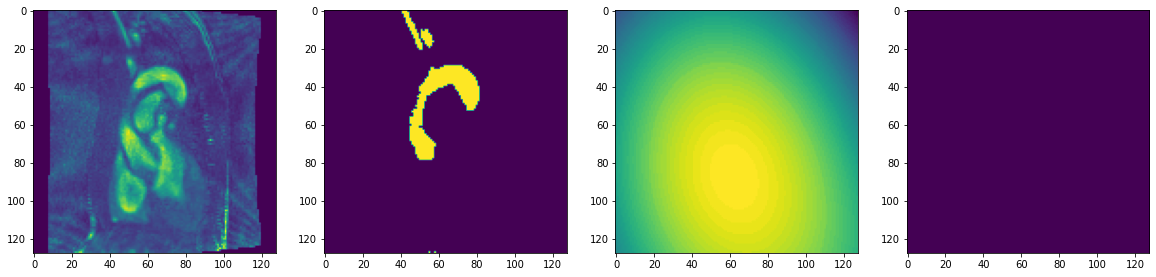

139, pcmra loss: 0.029, mask loss: 0.678, dice loss: 1.0


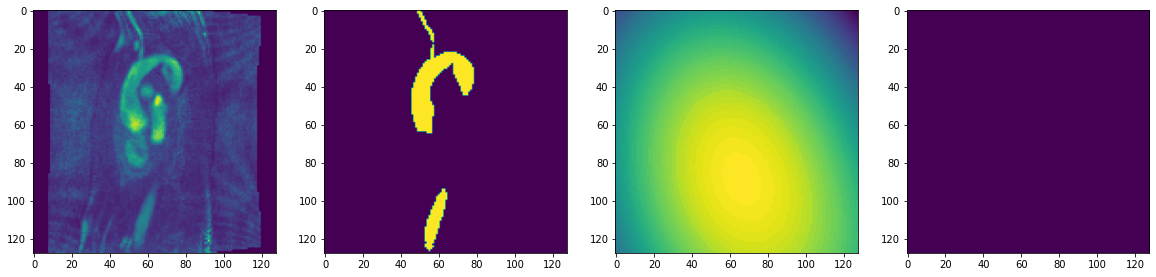

37, pcmra loss: 0.026, mask loss: 0.679, dice loss: 1.0


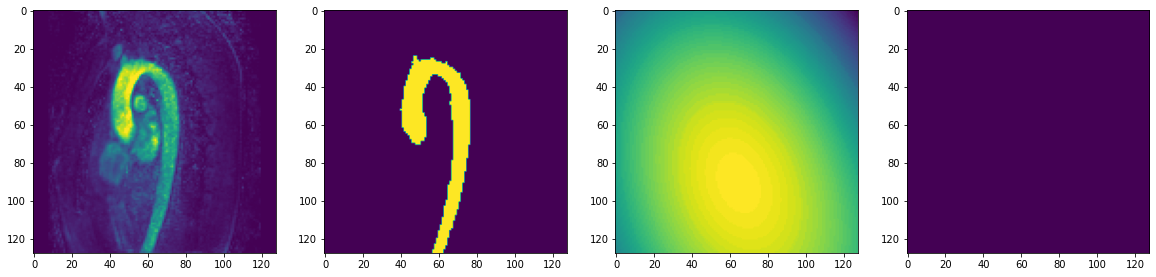

60, pcmra loss: 0.021, mask loss: 0.678, dice loss: 1.0


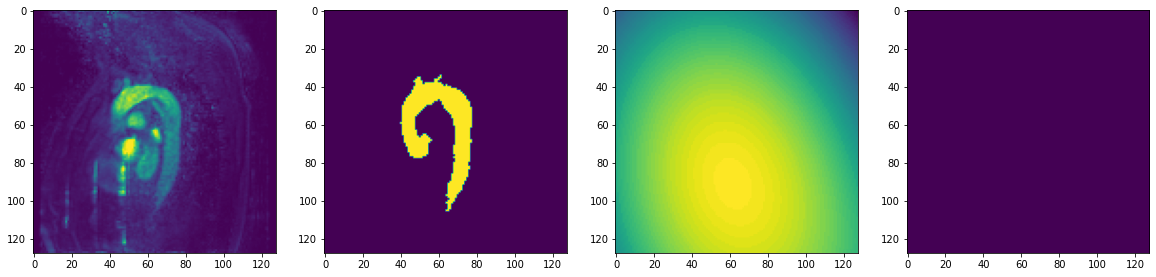

63, pcmra loss: 0.016, mask loss: 0.679, dice loss: 1.0


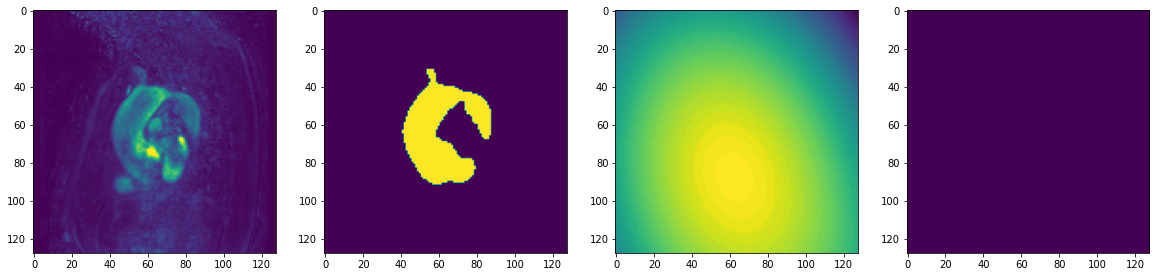

84, pcmra loss: 0.021, mask loss: 0.679, dice loss: 1.0


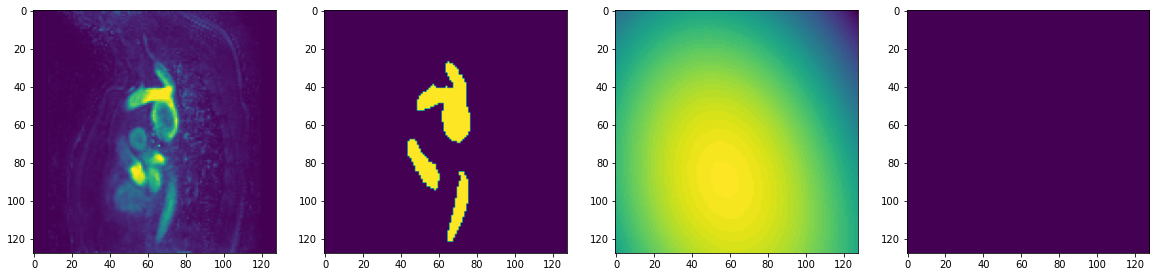

In [14]:
shape = [24, 128, 128]

runs = [
        ("pi_gan_2021_10_05_09_12_14___colab_sdf_test", "pi_gan_2021_10_05_09_12_14___colab_sdf_test", [24, 128, 128]),
        # ("pi_gan_2021_10_05_09_00_34__colab_sdf_test", "pi_gan_2021_10_05_09_00_34__colab_sdf_test", [24, 128, 128]),
        # ("pi_gan_2021_10_05_09_09_50_colab_sdf_test", "pi_gan_2021_10_05_09_09_50_colab_sdf_test", [24, 128, 128]),
        # ("pi_gan_2021_10_05_09_11_04__colab_sdf_test", "pi_gan_2021_10_05_09_11_04__colab_sdf_test", [24, 128, 128]),
        
        # ("segmentation_sdf_lambda_300", "segmentation_sdf_y", [24, 128, 128]),
        # ("segmentation_sdf_lambda_300", "segmentation_sdf_z", [24, 128, 128]),
        ]

for run, name, shape in runs:
    print(run)
    ARGS = load_args(run, print_changed=False)

    ARGS.print_models=False
    ARGS.pretrained_best_dataset = "val"

    if ARGS.training_setup == "reconstruction": 
        ARGS.pretrained_best_loss = "pcmra"
    else: 
        ARGS.pretrained_best_loss = "dice"

    # ARGS.pretrained_best_dataset = "train"
    # ARGS.pretrained_best_loss = "pcmra"

    models, optims, schedulers = initialize_models_and_optims(ARGS, DEVICE)

    load_pretrained_models(run, ARGS.pretrained_best_dataset, ARGS.pretrained_best_loss,
                           models, optims, DEVICE, pretrained_models=None)


    mask_outs = save_output(test_dl, name=name, shape=shape, transform=False)

# Save test results for all models

In [13]:
# # get losses
# for run in sorted(os.listdir(path='saved_runs')): 
#     if os.path.exists(f"saved_runs/{run}/ARGS.txt"):
#         if not os.path.exists(f"saved_runs/{run}/test_results.npy"):
#             print(run)

#             ARGS = load_args(run, print_changed=False)
#             ARGS.print_models=False

#             models, optims, schedulers = initialize_models_and_optims(ARGS, DEVICE)
            
#             blur_layer = initialize_blurring_layer(1.0, DEVICE)

#             test_results = test_epoch(test_dl, models, blur_layer, ARGS, DEVICE)